# Get Xarray data into a form usable by the model

## Loading data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Combined/sic-and-era5.zarr.tar sic-and-era5.zarr.tar

drive.flush_and_unmount()

Mounted at /content/drive


In [2]:
!tar -xf sic-and-era5.zarr.tar

In [3]:
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 65.0 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=237d520a94ddae4ab271e0063f8d3a043b8d87d4e4ec5b8010fc8dd5233ace55
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [4]:
import xarray as xr

In [5]:
data = xr.open_zarr('sic-and-era5.zarr').chunk({'time': 1, 'xc': 432, 'yc': 432})

## Preprocessing

To do: ideally some ways to undo some of this data preprocessing (e.g. getting back the time of each data point, un-normalizing values, ...)

In [6]:
import pandas as pd
import numpy as np

In [7]:
start_year = 1988
end_year = 2022

start_date = f'{start_year}-01-01'
end_date = f'{end_year}-12-01'

date_range = xr.date_range(start=start_date, end=end_date, freq='MS')

In [8]:
reindexed_data = data.reindex({'time': date_range})

In [9]:
# deal with sst and land since they're not quite like the other variables (land doesn't have the time dimension and sst has missing data values)
reindexed_data['land'] = reindexed_data['land'].expand_dims({'time': reindexed_data['time']})
reindexed_data['sst'] = reindexed_data['sst'].fillna(273.15) # arbitrarily fill missing SST values with 0 degrees C

In [10]:
# add seasonality data
scaled_months = 2 * np.pi * data.time.dt.month / 12
reindexed_data['cos_month'] = np.cos(scaled_months, dtype=np.float32).expand_dims({'xc': reindexed_data['xc'], 'yc': reindexed_data['yc']})
reindexed_data['sin_month'] = np.sin(scaled_months, dtype=np.float32).expand_dims({'xc': reindexed_data['xc'], 'yc': reindexed_data['yc']})

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [11]:
total_size = reindexed_data.sizes['time']
val_and_test_size = total_size // 4
val_start = total_size - val_and_test_size

# for normalization; only normalize with training data
reindexed_data_train = reindexed_data.isel(time=slice(0, val_start)) # to do... X[:val_start]

In [12]:
def normalize(data, mean_std_data=None, dims=('time', 'xc', 'yc'), epsilon=1e-6, return_m_s=False):
  if mean_std_data is None:
    mean_std_data = data
  means = mean_std_data.mean(dims, dtype=np.float64)
  stds = mean_std_data.std(dims, dtype=np.float64)
  # add epsilon in case some have 0 standard deviation
  normalized = (data - means) / (stds + epsilon)
  if return_m_s:
    return normalized, means, stds
  else:
    return normalized

In [13]:
%%time
# This part probably needs a high RAM runtime to run
normalized, means, stds = normalize(reindexed_data, mean_std_data=reindexed_data_train, return_m_s=True)
X = normalized.to_array().transpose('time', 'xc', 'yc', 'variable').astype(np.float32).to_numpy()

CPU times: user 1min 34s, sys: 19.7 s, total: 1min 54s
Wall time: 1min 23s


In [14]:
sic_0_to_1 = reindexed_data['concentration'] / 100
y = sic_0_to_1.transpose('time', 'xc', 'yc').astype(np.float32).to_numpy()

In [15]:
assert not np.isnan(X).any()
assert not np.isnan(y).any()

In [16]:
variable_list = tuple(reindexed_data.data_vars)

In [17]:
means_npy = means.to_array().to_numpy()
stds_npy = stds.to_array().to_numpy()

In [18]:
# save results
import pickle

np.save('X.npy', X)
np.save('y.npy', y)

with open('vars.pkl', 'wb') as f:
  pickle.dump(variable_list, f)

np.save('means.npy', means_npy)
np.save('stds.npy', stds_npy)

In [19]:
drive.mount('/content/drive')

!cp X.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/X.npy
!cp y.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/y.npy
!cp vars.pkl drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/vars.pkl
!cp means.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/means.npy
!cp stds.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/stds.npy

drive.flush_and_unmount()

Mounted at /content/drive


# Look at land mask

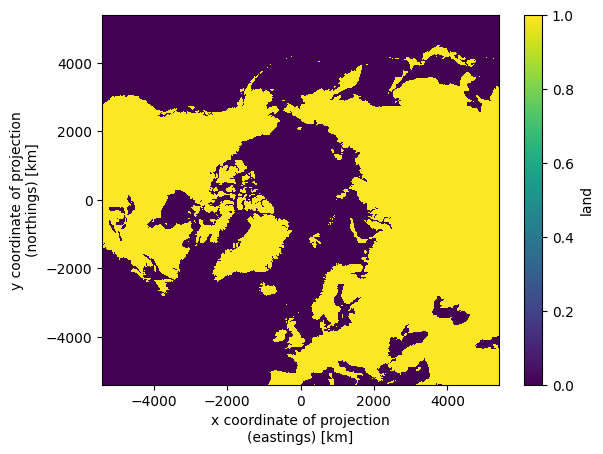

In [ ]:
data['land'].plot()

In [ ]:
data['land']

<xarray.DataArray 'land' (yc: 432, xc: 432)>
dask.array<open_dataset-land, shape=(432, 432), dtype=int8, chunksize=(432, 432), chunktype=numpy.ndarray>
Coordinates:
    lat      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03

In [ ]:
seas_mask = xr.load_dataarray('seas_mask.nc')

In [ ]:
seas_mask.sum() / seas_mask.count()

<xarray.DataArray 'sea_ice_region_surface_mask' ()>
array(0.19341028)

In [ ]:
import numpy as np

np.expand_dims(seas_mask.transpose('x', 'y').to_numpy(), -1).shape

(432, 432, 1)

In [ ]:
# to do: clean up the code used to get this
np.save('seas_mask.npy', np.expand_dims(seas_mask.transpose('x', 'y').to_numpy(), -1))

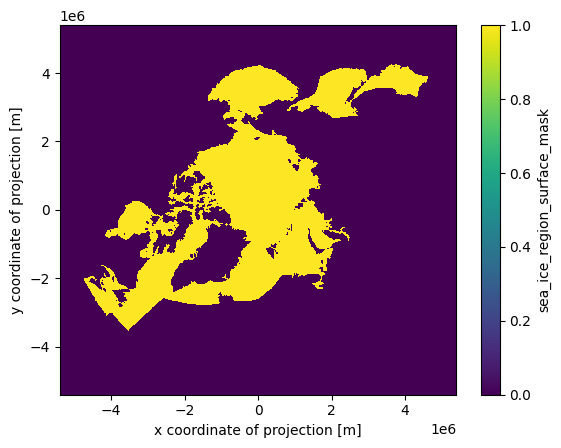

In [ ]:
seas_mask.plot();

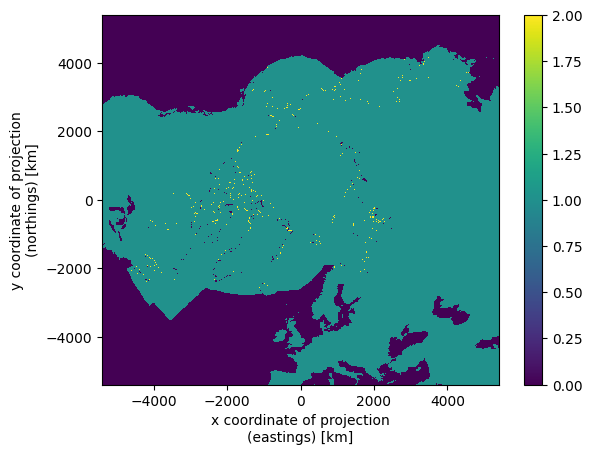

In [ ]:
(seas_mask.rename({'y': 'yc', 'x': 'xc'}).assign_coords({'yc': data.yc, 'xc': data.xc}) + data['land']).plot();

# UMAP

## Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/X.npy X.npy

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
import numpy as np

X = np.load('X.npy')

In [ ]:
# get X_train separately to train the UMAP on

total_size = len(X)
val_and_test_size = total_size // 4
val_start = total_size - val_and_test_size

X_train = X[:val_start]

## Performing UMAP

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=b341bad95383272afb72f9cfb2c02fddd7ac7565116632d78e44cfd9923be008
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=97c2847ceca63e5a9ede93bbfbbb017cae9366258c4554249b0645d7c898d75d
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
# flatten all but the first dimension
def flatten(array):
  return array.reshape((array.shape[0], -1))

def get_embedding(metric):
  # n_neighbors and min_dist have been set as the defaults
  reducer = umap.UMAP(n_neighbors=15, n_components=72, metric=metric, min_dist=0.1, random_state=42)
  reducer.fit(flatten(X_train))
  return reducer.transform(flatten(X))

In [ ]:
%%time
cosine_embedding = get_embedding('cosine')

CPU times: user 13min 20s, sys: 27.7 s, total: 13min 47s
Wall time: 14min 4s


In [ ]:
%%time
euclidean_embedding = get_embedding('euclidean')

CPU times: user 4min 22s, sys: 0 ns, total: 4min 22s
Wall time: 4min 24s


In [ ]:
np.save('cosine-umap.npy', cosine_embedding)
np.save('euclidean-umap.npy', euclidean_embedding)

In [ ]:
drive.mount('/content/drive')

!cp cosine-umap.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/cosine-umap.npy
!cp euclidean-umap.npy drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/euclidean-umap.npy

drive.flush_and_unmount()

Mounted at /content/drive
